# 2. 프로젝트: ResNet Ablation Study

## 루브릭
|평가문항|	상세기준|
|:-------|:-------|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

## 0) CIFAR-10 데이터셋 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 로드

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

* Tensorflow Datasets : https://www.tensorflow.org/datasets/catalog/overview
  - Audio
  - Graphs
  - Image
  - Image classification
  - Object detection
  - Question answering
  - Structured
  - Summarization
  - Text
  - Translate
  - Video
  - Vision language

### 불러온 데이터셋의 정보 확인

In [4]:
# 데이터셋 종류 확인 (시간이 오래걸림)
# tfds.list_builders()[:10]

* **cifar10** : Tensorflow Datasets / Image classification / Cifar10 에 있음
  - The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 
  - There are 50000 training images and 10000 test images.

In [5]:
# 데이터셋의 정보 확인
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='/home/aiffel-d34j/tensorflow_datasets/cifar10/3.0.2',
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features fr

In [6]:
# 데이터셋의 feature 정보 확인 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [7]:
# 데이터셋의 class 개수 확인 
print('class의 개수 :', ds_info.features['label'].num_classes)

class의 개수 : 10


In [8]:
# 데이터셋의 클래스 이름 확인
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
# 데이터셋의 train/test의 샘플 사이즈 확인
print('train 데이터 개수 :', ds_info.splits['train'].num_examples)
print('test 데이터 개수 :', ds_info.splits['test'].num_examples)

train 데이터 개수 : 50000
test 데이터 개수 : 10000


In [10]:
# 학습 및 테스트 데이터의 갯수 확인하는 다른 방법
print('train 데이터 개수 :', tf.data.experimental.cardinality(ds_train))
print('test 데이터 개수 :', tf.data.experimental.cardinality(ds_test))

train 데이터 개수 : tf.Tensor(50000, shape=(), dtype=int64)
test 데이터 개수 : tf.Tensor(10000, shape=(), dtype=int64)


### CPU 코어 개수 확인

In [11]:
# CPU 코어 전체 개수
! grep -c processor /proc/cpuinfo

12


* 일반적인 경우, 하이퍼스레딩에 의해 OS(윈도우, 리눅스 등)에서 코어 수가 실제 코어 수의 2배로 인식된다.
* 예를 들어 싱글코어는 코어 2개로, 듀얼코어는 4개로 인식된다.


* 지금 사용하는 컴퓨터의 경우 :
  - 가상 CPU 코어 수는 12. 따라서 물리적으로는 **6 코어**
  - [참고 : 리눅스 CPU 개수 확인](https://zetawiki.com/wiki/리눅스_CPU_개수_확인)

In [12]:
# 물리 CPU 개수
! grep ^processor /proc/cpuinfo | wc -l

12


In [13]:
# CPU당 물리 코어 개수
! grep 'cpu cores' /proc/cpuinfo | tail -1

cpu cores	: 6


### 불러온 데이터셋  이미지 확인

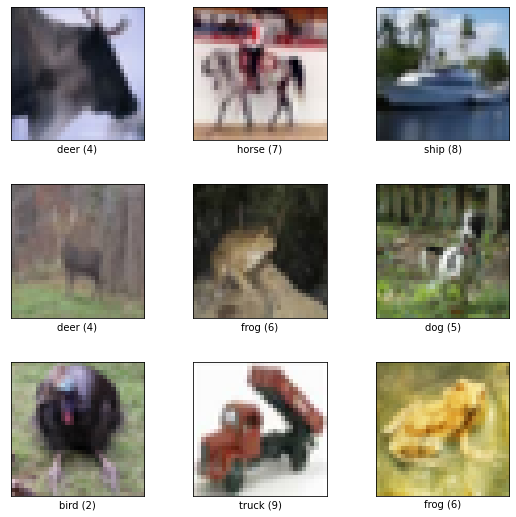

In [14]:
# 학습 데이터셋에 어떤 이미지 있는지 확인
fig = tfds.show_examples(ds_train, ds_info)

* **`tfds.show_examples(ds, info)`** : matplotlib.figure.Figure를 반환합니다 (현재 이미지 데이터 세트 만 지원됨) [참고](https://www.tensorflow.org/datasets/overview#tfdsshow_examples)
* **`tfds.visualization.show_examples(ds, ds_info)`** : 이미지 분류 데이터 세트에서 이미지 (및 레이블)를 시각화합니다. [참고](https://www.tensorflow.org/datasets/api_docs/python/tfds/visualization/show_examples)

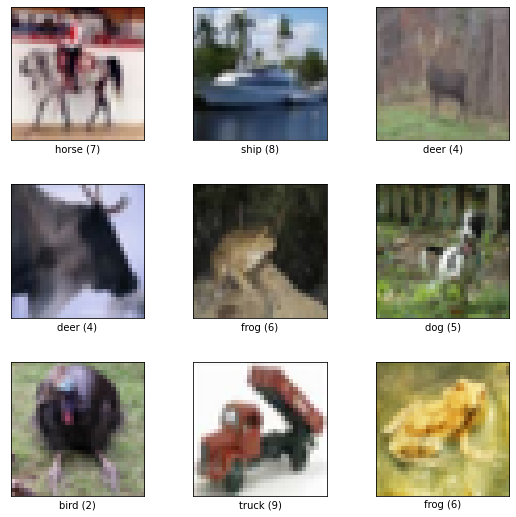

In [15]:
# 학습 데이터셋에 어떤 이미지 있는지 확인하는 다른 방법
fig = tfds.visualization.show_examples(ds_train, ds_info)

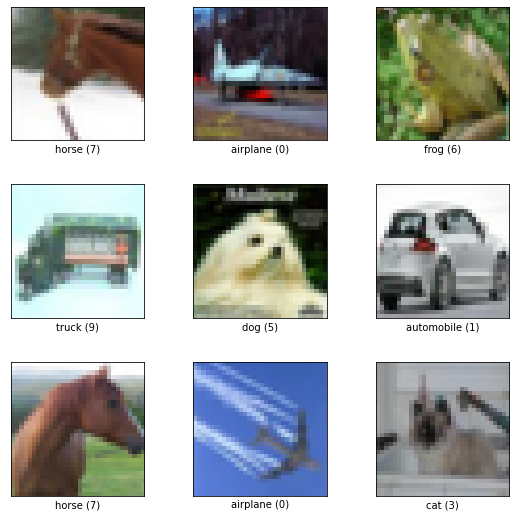

In [16]:
# 테스트 데이터셋에 어떤 이미지 있는지 확인
fig = tfds.show_examples(ds_test, ds_info)

### 데이터셋 정규화

In [17]:
# 정규화 및 이미지 크기조절 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [18]:
# 데이터셋에 정규화 함수를 적용하는 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    # 위에서 만든 normalize 함수를 병렬로 map 하기
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=6      # 병렬처리할 때 가용할 CPU 코어 개수
    )
    # split dataset into batches of batch_size
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()      # repeat process for number of epochs
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* **`num_parallel_calls`** :
  - map 변환을 병렬 처리한다.
  - 병렬 처리 레벨을 지정하기 위해 num_parallel_calls 인수를 제공합니다.
  - 가용한 CPU 코어 숫자보다 훨씬 더 많이 설정한다면 비효율적인 스케줄링으로 느려질 것입니다.
  - [참고 1: tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance?hl=ko)
  - [참고 2: tf.data API로 성능 향상하기](https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/data_performance.ipynb?hl=ko)
  
  
* **`ds.batch(batch_size)`** : 데이터 세트를 batch_size의 배치로 분할 [참고](https://wsstudynote.tistory.com/24)
* **`ds.repeat(num_epochs)`** : num_epochs 수에 대해 프로세스를 반복  [참고](https://wsstudynote.tistory.com/24)
* **`ds.shuffle(SHUFFLE_BUFFER_SIZE)`** : 데이터를 랜덤하게 셔플하는 기능 [참고: shuffle()에서 buffer_size의 중요성](https://helloyjam.github.io/tensorflow/buffer-size-in-shuffle/)
  - SHUFFLE_BUFFER_SIZE=len(filenames)을 사용 
  - 이미지 읽고 프로세싱하고 배치작업등의 무거운 작업을 하기전에 tf.data.Dataset.shuffle()을 호출
* **`ds.prefetch()`** : [참고](https://www.tensorflow.org/guide/data_performance?hl=ko)
  - 모델이 s스텝 훈련을 실행하는 동안 입력 파이프라인은 s+1스텝의 데이터를 읽습니다
  - 훈련을 하는 최대(합과 반대로) 스텝 시간과 데이터를 추출하는 데 걸리는 시간을 단축시킬 수 있습니다.
  - 이 변환은 백그라운드 스레드와 내부 버퍼를 사용하여 요청된 시간 전에 입력 데이터셋에서 요소를 가져옵니다. 
  - 가져올 요소의 수는 하나의 훈련 스텝에서 소비한 배치의 수와 같거나 커야 합니다
  - 이 값을 수동으로 조정하거나 
  - **`tf.data.experimental.AUTOTUNE`** 으로 설정하면 tf.data 런타임이 실행 시에 **동적으로 값을 조정**하도록 만듭니다.

## 1) ResNet 기본 블록 구성하기

ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 찾아서  
ResNet의 기본 블록, 또는 Residual 블록(residual block)을 구현해보기.  
가급적 ResNet 논문을 통해서 구현방법에 대한 정보를 얻으시기를 권합니다.

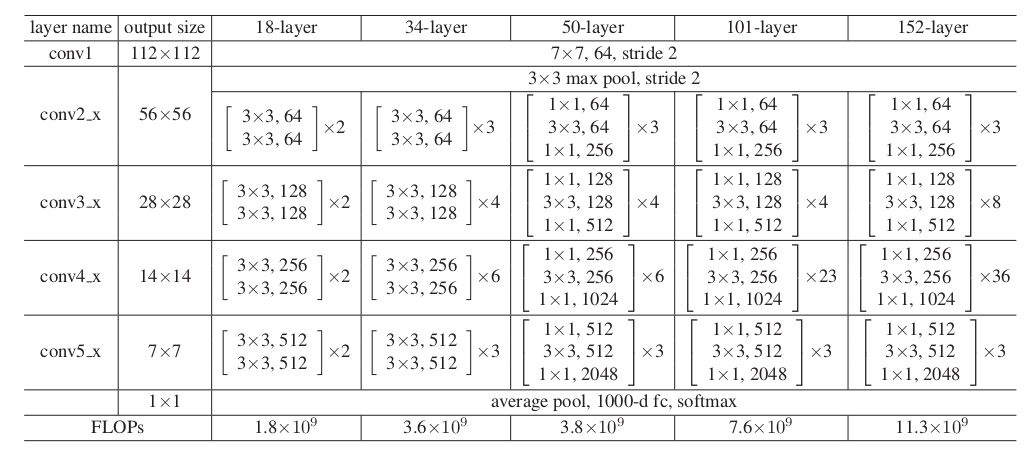
<div style='text-align:left'>Table 1. Architectures for ImageNet. Building blocks are shown in brackets (see also Fig. 5), with the numbers of blocks stacked.</div>   
<div style='text-align:left'>Down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2. </div>

* ResNet-34와 ResNet-50 **공통점** : 
  - conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태
  
  
* ResNet-34와 ResNet-50 **차이점** :
  - ResNet-34 : 3x3 kernel인 Convolution layer로만 구성
  - ResNet-50 : 1x1 Convolution layer가 3x3 Convolution layer의 앞뒤로 붙어있음
    - 뒤에 있는 1x1 Convolution layer의 채널 수는 앞에 있는 것의 4배

[참고1](https://jmyao17.github.io/Machine_Learning/Neural_Network/ResNet/ResNet.html)  
[참고2](https://jisuhan.tistory.com/entry/CNN-ResNet50-톺아보기-구조와-코드-분석)  
[참고3](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)  
[참고4](https://www.programmersought.com/article/58524297511/)  
[참고5](https://eremo2002.tistory.com/76)
[참고6](https://pylessons.com/Keras-ResNet-tutorial/)
[참고7](https://keras.io/api/applications/resnet/#resnet50-function)
[참고8](https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/applications/resnet.py#L453-L472)

### tf.keras.applications.ResNet50 분석

**ResNet models for Keras.  
Reference:**
  - [Deep Residual Learning for Image Recognition](
      https://arxiv.org/abs/1512.03385) (CVPR 2015)

### Building blocks of ResNet-34 & ResNet-50 (Bottleneck)

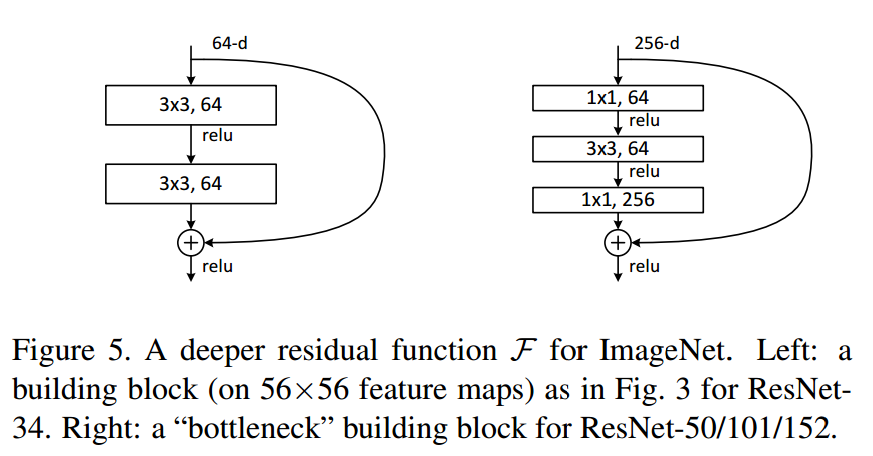

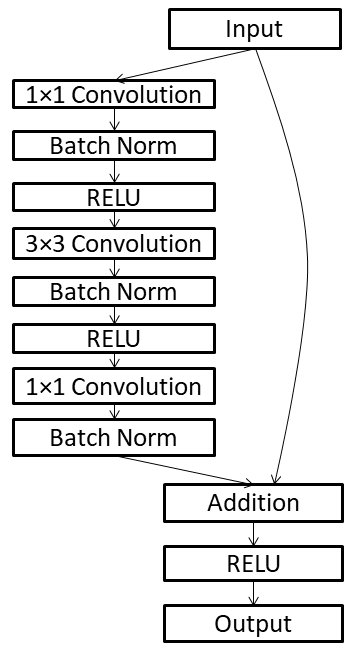

### Building block 구성

* **[3.4. Implementation](https://arxiv.org/pdf/1512.03385.pdf)**  
Our implementation for ImageNet follows the practice in [21, 41]. 
  - 1) The image is **resized** with its shorter side randomly sampled in [256, 480] for **scale augmentation** [41].  
  - 2) A **224×224 crop** is randomly sampled from an image or its **horizontal flip**, with the per-pixel mean subtracted [21].   
  - 3) The **standard color augmentation** in [21] is used.   
  - 4) We adopt **batch normalization (BN)** [16] **right after each convolution** and **before activation**, following [16].   
  - 5) We **initialize the weights** as in [13] and train all plain/residual nets from scratch.   
  - 6) We use **SGD** with a **mini-batch size of 256**.   
  - 7) The **learning rate** starts from **0.1** and is **divided by 10 when the error plateaus**, and the models are trained for up to **60 × $10^4$ iterations**.   
  - 8) We use a **weight decay of 0.0001** and a **momentum of 0.9**.   
  - 9) We do **not use dropout** [14], following the practice in [16].  

In testing, for comparison studies we adopt the standard 10-crop testing [21].   
For best results, we adopt the fullyconvolutional form as in [41, 13], and average the scores at multiple   scales (images are resized such that the shorter side is in f224; 256; 384; 480; 640g).

* 그림 5로부터 : conv1x1, conv3x3 layer 필요함
* 4) 조건으로부터 : Convolution --> Batch Normalization --> Activation

* **Deeper Bottleneck Architectures.**   

Next we describe our deeper nets for ImageNet.   
Because of concerns on the training time that we can afford, 
we modify the building block as a **bottleneck design.**
  - For each residual function F, we use a stack of **3 layers instead of 2** (Fig. 5).   
  - The three layers are **1×1, 3×3, and 1×1 convolutions**,   
    - where the **1×1 layer**s are responsible for **reducing** and then **increasing** (restoring) dimensions,   
    - leaving the **3×3 layer** a bottleneck with smaller input/output dimensions.  
    
Fig. 5 shows an example, where both designs have similar time complexity.  
The parameter-free identity shortcuts are particularly important for the bottleneck architectures.   
If the identity shortcut in Fig. 5 (right) is replaced with projection,   
  one can show that the time complexity and model size are doubled,  
  as the shortcut is connected to the two high-dimensional ends. 
So identity shortcuts lead to more efficient models for the bottleneck designs.



* **50-layer ResNet**:      

  - We replace each **2-layer block** in the 34-layer net with this **3-layer bottleneck block**,
    - resulting in a 50-layer ResNet (Table 1).   
  - We use option B for increasing dimensions.   
  - This model has 3.8 billion FLOPs.

### 50-layer residual

* [참고:Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)  
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
    use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None, **kwargs
)


* [참고:BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)  
tf.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones', beta_regularizer=None,
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None,
    renorm=False, renorm_clipping=None, renorm_momentum=0.99, fused=None,
    trainable=True, virtual_batch_size=None, adjustment=None, name=None, **kwargs
)


* [참고:Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation)  
tf.keras.layers.Activation(
    activation, **kwargs
)


* [참고:ZeroPadding2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D)  
tf.keras.layers.ZeroPadding2D(
    padding=(1, 1), data_format=None, **kwargs
)

### ResNet50 구성

#### identity shortcut block :

<img align='center' width='90%' src='https://pylessons.com/static/images/CNN-tutorials/Keras-ResNet-tutorial/Identity_block2.png'/>


####  projection shortcut block:

<img align='center' width='90%' src='https://pylessons.com/static/images/CNN-tutorials/Keras-ResNet-tutorial/Identity_block3.png'/>

#### Building the ResNet model (50 layers):

<img align='center' width='90%' src='https://pylessons.com/static/images/CNN-tutorials/Keras-ResNet-tutorial/ResNet-50.png'/>

[참고:Blocks with dotted line represents modules](https://www.researchgate.net/figure/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be_fig3_331364877)  
[참고: modified ResNet-50](https://www.researchgate.net/figure/Transfer-learning-architecture-with-modified-ResNet-50-and-ResNet-101-model-n-6-for_fig7_335534416)  
[참고:ResNet-50 network architectures](https://www.researchgate.net/figure/ResNet-50-network-architectures-It-includes-convolution-block-and-identity-block_fig3_338986286)

## 2) ResNet-34, ResNet-50 Complete Model

### ResNet  구현 
[참고](https://github.com/calmisential/TensorFlow2.0_ResNet)

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence

* ResNet34 와 ResNet50의 구조는 다르기 때문에 구분하여 작성한다.
  - <span style='color:red'> **ResNet34** : basic_block, skip_basic_block; basic_block_layer; resnet_type1 </span>
  - <span style='color:red'>**ResNet50** : bottle_neck, skip_bottle_neck; bottle_neck_layer; resnet_type2 </span>

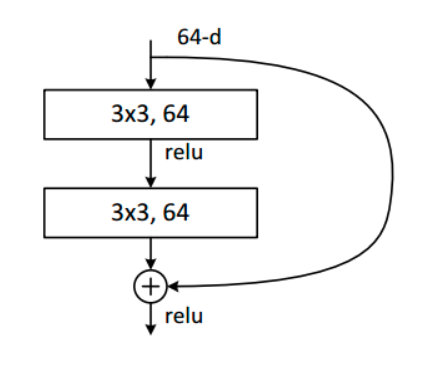  

In [20]:
# basic block for resnet type 1
def basic_block(inputs, n_filter, stride, bk):
    print('basic_block_input    :', bk, inputs.shape)
    
    shortcut = inputs
    
    x = Conv2D(filters=n_filter, kernel_size=(3, 3), strides=stride, padding="same")(inputs)
    x   = BatchNormalization()(x)
    x  = Activation("relu")(x)
    x = Conv2D(filters=n_filter, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x   = BatchNormalization()(x)
    print('basic_block_beforadd :', bk, x.shape)
    
    shortcut = skip_basic_block(shortcut, n_filter, stride, bk)
    print('basic_block_shortcut :', bk, shortcut.shape) 
    
    x = Add()([x, shortcut])
    output  = Activation("relu")(x)
    print('basic_block_output   :', bk, output.shape)
    
    return output

* `padding="same"` : # of padding = # of filters / 2
* $output=(n - f + 2p)/s + 1$   
* $output = n/s + 1$ at "same"

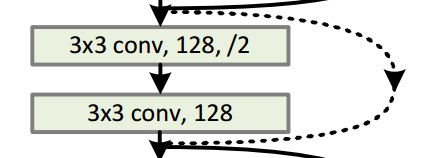

In [21]:
# skip connection for resnet type 1
def skip_basic_block(inputs, n_filter, stride, bk):
    print('skip_basic_block_input :', bk, inputs.shape)
    
    if stride != (1, 1):
        # projection shortcut
        shortcut = Conv2D(filters=n_filter, kernel_size=(3, 3), strides=stride, padding="same")(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        # identity shortcut
        shortcut = inputs
        
    print('skip_basic_block_output:', bk, shortcut.shape)    
    return shortcut

*  <span style='color:red'> ResNet34의 첫번째 skip connection은 identity shortcut으로 구성되어 있으므로 주의해야 한다.</span>

In [22]:
# layers of basic block of resnet type1
def basic_block_layer(inputs, n_filter, blocks, stride=(1, 1)):
    print('basic_block_laye r_input:', inputs.shape)
    bk = 0
    resnet_block = basic_block(inputs, n_filter, stride=stride, bk=0)
    
    for _ in range(1, blocks):
        bk = bk + 1
        resnet_block = basic_block(resnet_block, n_filter, stride=(1, 1), bk=bk)
        
    return resnet_block

In [23]:
def resnet_type1(inputs, layer_params):
    print('resnet_type1_input:', inputs.shape)
    
    conv1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
    bn1 = BatchNormalization()(conv1)
    act1  = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(act1)
    print('resnet_type1_pool1:', pool1.shape)
    
    layer1 = basic_block_layer(pool1,  n_filter=64,  blocks=layer_params[0], stride=(1, 1))
    layer2 = basic_block_layer(layer1, n_filter=128, blocks=layer_params[1], stride=(2, 2))
    layer3 = basic_block_layer(layer2, n_filter=256, blocks=layer_params[2], stride=(2, 2))
    layer4 = basic_block_layer(layer3, n_filter=512, blocks=layer_params[3], stride=(2, 2))
    
    avgpool = GlobalAveragePooling2D()(layer4)
    outputs = Dense(units=n_classes, activation='softmax')(avgpool)
    print('resnet_type1_output  :', outputs.shape)
    
    resnet_model = Model(inputs, outputs)
    
    return resnet_model

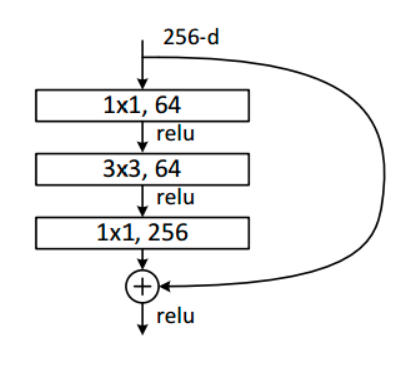

In [24]:
# bottle neck block for resnet type 2
def bottle_neck(inputs, n_filter, stride, bk):
    print('bottle_neck_input      :', bk, inputs.shape)
    
    shortcut = inputs
    
    conv1 = Conv2D(filters=n_filter, kernel_size=(1, 1), strides=stride)(inputs)
    print('conv1 :', bk, conv1.shape)
    bn1   = BatchNormalization()(conv1)
    act1  = Activation("relu")(bn1)
    conv2 = Conv2D(filters=n_filter, kernel_size=(3, 3), strides=(1, 1), padding="same")(act1)
    print('conv2 :', bk, conv2.shape)
    bn2   = BatchNormalization()(conv2)
    act2  = Activation("relu")(bn2)
    conv3 = Conv2D(filters=n_filter*4, kernel_size=(1, 1), strides=(1, 1))(act2)
    print('conv3 :', bk, conv3.shape)
    bn3   = BatchNormalization()(conv3)
    print('bottle_neck_beforadd :', bk, bn3.shape)
    
    shortcut = skip_bottle_neck(shortcut, n_filter*4, stride, bk)
    print('bottle_neck_shortcut :', bk, shortcut.shape)    
    
    add4 = Add()([bn3, shortcut])
    outputs  = Activation("relu")(add4)
    print('bottle_neck_output     :', bk, outputs.shape)
    
    return outputs

* <span style='color:red'> conv3의 필터개수가 conv1의 필터개수보다 4배 많은 것에 주의해야한다. </span>
* <span style='color:red'> skip connection의 필터 개수 또한 4배 많게 설정해야한다.</span>

In [25]:
# skip connection for resnet type 2
def skip_bottle_neck(inputs, n_filter, stride, bk):
    print('skip_bottle_neck_input :', bk, inputs.shape)
    
    if bk==0:
        # projection shortcut
        shortcut = Conv2D(filters=n_filter, kernel_size=(1, 1), strides=stride)(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        # identity shortcut
        shortcut = inputs
        
    print('skip_bottle_neck_output:', bk, shortcut.shape)
    return shortcut

* <span style='color:red'> resnet50은 모든 레이어에서 첫번째 skip connection에 projection shortcut을 적용한다.</span>

In [26]:
# layers of bottle neck of resnet type 2
def bottle_neck_layer(inputs, n_filter, blocks, stride=(1, 1)):
    print('bottle_neck_layer_input:', inputs.shape)
    bk = 0
    resnet_block = bottle_neck(inputs, n_filter, stride=stride, bk=0)
    
    for _ in range(1, blocks):
        bk = bk + 1
        resnet_block = bottle_neck(resnet_block, n_filter, stride=(1, 1), bk=bk)
        
    return resnet_block

In [27]:
def resnet_type2(inputs, layer_params):
    print('resnet_type2_input:', inputs.shape)
    
    conv1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
    bn1 = BatchNormalization()(conv1)
    act1  = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(act1)
    print('resnet_type2_pool1:', pool1.shape)
    
    layer1 = bottle_neck_layer(pool1,  n_filter=64,  blocks=layer_params[0], stride=(1, 1))
    layer2 = bottle_neck_layer(layer1, n_filter=128, blocks=layer_params[1], stride=(2, 2))
    layer3 = bottle_neck_layer(layer2, n_filter=256, blocks=layer_params[2], stride=(2, 2))
    layer4 = bottle_neck_layer(layer3, n_filter=512, blocks=layer_params[3], stride=(2, 2))
    
    avgpool = GlobalAveragePooling2D()(layer4)
    outputs = Dense(units=n_classes, activation='softmax')(avgpool)
    print('resnet_type2_output  :', outputs.shape)
    
    resnet_model = Model(inputs, outputs)

    return resnet_model

In [28]:
def resnet_18(inputs):
    return resnet_type1(inputs, layer_params=[2, 2, 2, 2])


def resnet_34(inputs):
    return resnet_type1(inputs, layer_params=[3, 4, 6, 3])


def resnet_50(inputs):
    return resnet_type2(inputs, layer_params=[3, 4, 6, 3])


def resnet_101(inputs):
    return resnet_type2(inputs, layer_params=[3, 4, 23, 3])


def resnet_152(inputs):
    return resnet_type2(inputs, layer_params=[3, 8, 36, 3])

In [42]:
def build_resnet(input_shape=input_shape, is_50=True):

    input_tensor = Input(shape=input_shape, dtype='float32', name='input_layer')
    
    if not is_50:
        resnet = resnet_34(input_tensor)
    else:
        resnet = resnet_50(input_tensor)
        
    return resnet


### ResNet-34

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다.
ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet() 를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

`resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()`

In [43]:
input_shape = (32, 32, 3)
n_classes = 10

resnet_34_model = build_resnet(input_shape=input_shape, is_50=False)
resnet_34_model.summary()

resnet_type1_input: (None, 32, 32, 3)
resnet_type1_pool1: (None, 8, 8, 64)
basic_block_laye r_input: (None, 8, 8, 64)
basic_block_input    : 0 (None, 8, 8, 64)
basic_block_beforadd : 0 (None, 8, 8, 64)
skip_basic_block_input : 0 (None, 8, 8, 64)
skip_basic_block_output: 0 (None, 8, 8, 64)
basic_block_shortcut : 0 (None, 8, 8, 64)
basic_block_output   : 0 (None, 8, 8, 64)
basic_block_input    : 1 (None, 8, 8, 64)
basic_block_beforadd : 1 (None, 8, 8, 64)
skip_basic_block_input : 1 (None, 8, 8, 64)
skip_basic_block_output: 1 (None, 8, 8, 64)
basic_block_shortcut : 1 (None, 8, 8, 64)
basic_block_output   : 1 (None, 8, 8, 64)
basic_block_input    : 2 (None, 8, 8, 64)
basic_block_beforadd : 2 (None, 8, 8, 64)
skip_basic_block_input : 2 (None, 8, 8, 64)
skip_basic_block_output: 2 (None, 8, 8, 64)
basic_block_shortcut : 2 (None, 8, 8, 64)
basic_block_output   : 2 (None, 8, 8, 64)
basic_block_laye r_input: (None, 8, 8, 64)
basic_block_input    : 0 (None, 8, 8, 64)
basic_block_beforadd : 0 (Non

### ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

다음의 코드를 실행하면, 아래의 결과가 나와야 합니다.

`resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()`

In [44]:
input_shape = (32, 32, 3)
n_classes = 10

resnet_50_model = build_resnet(input_shape=input_shape, is_50=True)
resnet_50_model.summary()

resnet_type2_input: (None, 32, 32, 3)
resnet_type2_pool1: (None, 8, 8, 64)
bottle_neck_layer_input: (None, 8, 8, 64)
bottle_neck_input      : 0 (None, 8, 8, 64)
conv1 : 0 (None, 8, 8, 64)
conv2 : 0 (None, 8, 8, 64)
conv3 : 0 (None, 8, 8, 256)
bottle_neck_beforadd : 0 (None, 8, 8, 256)
skip_bottle_neck_input : 0 (None, 8, 8, 64)
skip_bottle_neck_output: 0 (None, 8, 8, 256)
bottle_neck_shortcut : 0 (None, 8, 8, 256)
bottle_neck_output     : 0 (None, 8, 8, 256)
bottle_neck_input      : 1 (None, 8, 8, 256)
conv1 : 1 (None, 8, 8, 64)
conv2 : 1 (None, 8, 8, 64)
conv3 : 1 (None, 8, 8, 256)
bottle_neck_beforadd : 1 (None, 8, 8, 256)
skip_bottle_neck_input : 1 (None, 8, 8, 256)
skip_bottle_neck_output: 1 (None, 8, 8, 256)
bottle_neck_shortcut : 1 (None, 8, 8, 256)
bottle_neck_output     : 1 (None, 8, 8, 256)
bottle_neck_input      : 2 (None, 8, 8, 256)
conv1 : 2 (None, 8, 8, 64)
conv2 : 2 (None, 8, 8, 64)
conv3 : 2 (None, 8, 8, 256)
bottle_neck_beforadd : 2 (None, 8, 8, 256)
skip_bottle_neck_in

## 3) 일반 네트워크(plain network) 만들기

### 블록 코드 수정하기

우리는 앞에서 ResNet 모델을 구현했습니다.   
ResNet의 핵심 아이디어는 **skip connection과 residual network**기 때문에,   
ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다.   
위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 **skip connection이 없는 블록을 만들 수 있도록 기능을 추가**해 주세요!

### plain network 구현

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence

In [33]:
# basic block for plainnet type 1
def plain_basic_block(inputs, n_filter, stride, bk):
    print('basic_block_input    :', bk, inputs.shape)
    
    shortcut = inputs
    
    x = Conv2D(filters=n_filter, kernel_size=(3, 3), strides=stride, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filter, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    print('basic_block_beforadd :', bk, x.shape)
    
    output  = Activation("relu")(x)
    print('basic_block_output   :', bk, output.shape)
    
    return output


# layers of basic block of plainnet type 1
def plain_basic_block_layer(inputs, n_filter, blocks, stride=(1, 1)):
    print('basic_block_laye r_input:', inputs.shape)
    bk = 0
    resnet_block = plain_basic_block(inputs, n_filter, stride=stride, bk=0)
    
    for _ in range(1, blocks):
        bk = bk + 1
        resnet_block = plain_basic_block(resnet_block, n_filter, stride=(1, 1), bk=bk)
        
    return resnet_block


def plainnet_type1(inputs, layer_params):
    print('resnet_type1_input:', inputs.shape)
    
    conv1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
    bn1 = BatchNormalization()(conv1)
    act1  = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(act1)
    print('resnet_type1_pool1:', pool1.shape)
    
    layer1 = plain_basic_block_layer(pool1,  n_filter=64,  blocks=layer_params[0], stride=(1, 1))
    layer2 = plain_basic_block_layer(layer1, n_filter=128, blocks=layer_params[1], stride=(2, 2))
    layer3 = plain_basic_block_layer(layer2, n_filter=256, blocks=layer_params[2], stride=(2, 2))
    layer4 = plain_basic_block_layer(layer3, n_filter=512, blocks=layer_params[3], stride=(2, 2))
    
    avgpool = GlobalAveragePooling2D()(layer4)
    outputs = Dense(units=n_classes, activation='softmax')(avgpool)
    print('resnet_type1_output  :', outputs.shape)
    
    model = Model(inputs, outputs)
    
    return model

In [34]:
# bottle neck block for plainnet type 2
def plain_bottle_neck(inputs, n_filter, stride, bk):
    print('bottle_neck_input      :', bk, inputs.shape)
    
    shortcut = inputs
    
    x = Conv2D(filters=n_filter, kernel_size=(1, 1), strides=stride)(inputs)
    print('conv1 :', bk, x.shape)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filter, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    print('conv2 :', bk, x.shape)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filter*4, kernel_size=(1, 1), strides=(1, 1))(x)
    print('conv3 :', bk, x.shape)
    x = BatchNormalization()(x)
    print('bottle_neck_beforadd :', bk, x.shape)
    
    output  = Activation("relu")(x)
    print('bottle_neck_output     :', bk, output.shape)
    
    return output


# layers of bottle neck of plainnet type 2
def plain_bottle_neck_layer(inputs, n_filter, blocks, stride=(1, 1)):
    print('bottle_neck_layer_input:', inputs.shape)
    bk = 0
    resnet_block = plain_bottle_neck(inputs, n_filter, stride=stride, bk=0)
    
    for _ in range(1, blocks):
        bk = bk + 1
        resnet_block = plain_bottle_neck(resnet_block, n_filter, stride=(1, 1), bk=bk)
        
    return resnet_block


def plainnet_type2(inputs, layer_params):
    print('resnet_type2_input:', inputs.shape)
    
    conv1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
    bn1 = BatchNormalization()(conv1)
    act1  = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(act1)
    print('resnet_type2_pool1:', pool1.shape)
    
    layer1 = plain_bottle_neck_layer(pool1,  n_filter=64,  blocks=layer_params[0], stride=(1, 1))
    layer2 = plain_bottle_neck_layer(layer1, n_filter=128, blocks=layer_params[1], stride=(2, 2))
    layer3 = plain_bottle_neck_layer(layer2, n_filter=256, blocks=layer_params[2], stride=(2, 2))
    layer4 = plain_bottle_neck_layer(layer3, n_filter=512, blocks=layer_params[3], stride=(2, 2))
    
    avgpool = GlobalAveragePooling2D()(layer4)
    outputs = Dense(units=n_classes, activation='softmax')(avgpool)
    print('resnet_type2_output  :', outputs.shape)
    
    plain_model = Model(inputs, outputs)

    return plain_model

In [35]:
def plainnet_18(inputs):
    return plainnet_type1(inputs, layer_params=[2, 2, 2, 2])


def plainnet_34(inputs):
    return plainnet_type1(inputs, layer_params=[3, 4, 6, 3])


def plainnet_50(inputs):
    return plainnet_type2(inputs, layer_params=[3, 4, 6, 3])


def plainnet_101(inputs):
    return plainnet_type2(inputs, layer_params=[3, 4, 23, 3])


def plainnet_152(inputs):
    return plainnet_type2(inputs, layer_params=[3, 8, 36, 3])

### 전체 함수 코드 수정하기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다.   
- **ResNet-50과 ResNet-34**, 그리고 
- 같은 레이어를 가지지만 skip connection이 없는 **PlainNet-50과 PlainNet-34**를 
- 만들 수 있는 함수 **build_plainnet()** 를 만들어 보세요.   
- 이때 입력 이미지의 크기는 **(224, 224, 3)** 으로 해주세요.

In [45]:
def build_plainnet(input_shape=input_shape, is_50=True, is_plain=True):

    input_tensor = Input(shape=input_shape, dtype='float32', name='plain_input_layer')
    
    if not is_50 and is_plain:
        plainnet = plainnet_34(input_tensor)
    elif is_50 and is_plain:
        plainnet = plainnet_50(input_tensor)
    else:
        pass
        
    return plainnet


### PlainNet-34

In [46]:
input_shape = (224, 224, 3)
n_classes = 10

plainnet_34_model = build_plainnet(input_shape=input_shape, is_50=False, is_plain=True)
plainnet_34_model.summary()

resnet_type1_input: (None, 224, 224, 3)
resnet_type1_pool1: (None, 56, 56, 64)
basic_block_laye r_input: (None, 56, 56, 64)
basic_block_input    : 0 (None, 56, 56, 64)
basic_block_beforadd : 0 (None, 56, 56, 64)
basic_block_output   : 0 (None, 56, 56, 64)
basic_block_input    : 1 (None, 56, 56, 64)
basic_block_beforadd : 1 (None, 56, 56, 64)
basic_block_output   : 1 (None, 56, 56, 64)
basic_block_input    : 2 (None, 56, 56, 64)
basic_block_beforadd : 2 (None, 56, 56, 64)
basic_block_output   : 2 (None, 56, 56, 64)
basic_block_laye r_input: (None, 56, 56, 64)
basic_block_input    : 0 (None, 56, 56, 64)
basic_block_beforadd : 0 (None, 28, 28, 128)
basic_block_output   : 0 (None, 28, 28, 128)
basic_block_input    : 1 (None, 28, 28, 128)
basic_block_beforadd : 1 (None, 28, 28, 128)
basic_block_output   : 1 (None, 28, 28, 128)
basic_block_input    : 2 (None, 28, 28, 128)
basic_block_beforadd : 2 (None, 28, 28, 128)
basic_block_output   : 2 (None, 28, 28, 128)
basic_block_input    : 3 (None,

### PlainNet-50

In [47]:
input_shape = (224, 224, 3)
n_classes = 10

plainnet_50_model = build_plainnet(input_shape=input_shape, is_50=True, is_plain=True)
plainnet_50_model.summary()

resnet_type2_input: (None, 224, 224, 3)
resnet_type2_pool1: (None, 56, 56, 64)
bottle_neck_layer_input: (None, 56, 56, 64)
bottle_neck_input      : 0 (None, 56, 56, 64)
conv1 : 0 (None, 56, 56, 64)
conv2 : 0 (None, 56, 56, 64)
conv3 : 0 (None, 56, 56, 256)
bottle_neck_beforadd : 0 (None, 56, 56, 256)
bottle_neck_output     : 0 (None, 56, 56, 256)
bottle_neck_input      : 1 (None, 56, 56, 256)
conv1 : 1 (None, 56, 56, 64)
conv2 : 1 (None, 56, 56, 64)
conv3 : 1 (None, 56, 56, 256)
bottle_neck_beforadd : 1 (None, 56, 56, 256)
bottle_neck_output     : 1 (None, 56, 56, 256)
bottle_neck_input      : 2 (None, 56, 56, 256)
conv1 : 2 (None, 56, 56, 64)
conv2 : 2 (None, 56, 56, 64)
conv3 : 2 (None, 56, 56, 256)
bottle_neck_beforadd : 2 (None, 56, 56, 256)
bottle_neck_output     : 2 (None, 56, 56, 256)
bottle_neck_layer_input: (None, 56, 56, 256)
bottle_neck_input      : 0 (None, 56, 56, 256)
conv1 : 0 (None, 28, 28, 128)
conv2 : 0 (None, 28, 28, 128)
conv3 : 0 (None, 28, 28, 512)
bottle_neck_bef

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### Ablation Study

In [39]:
BATCH_SIZE = 256
EPOCH = 5

In [40]:
#  CIFAR-10 데이터셋을 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

####  ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습

#### ResNet-50

In [48]:
del resnet_50_model

input_shape = (224, 224, 3)
n_classes = 10

resnet_50_model = build_resnet(input_shape=input_shape, is_50=True)
resnet_50_model.summary()

resnet_type2_input: (None, 224, 224, 3)
resnet_type2_pool1: (None, 56, 56, 64)
bottle_neck_layer_input: (None, 56, 56, 64)
bottle_neck_input      : 0 (None, 56, 56, 64)
conv1 : 0 (None, 56, 56, 64)
conv2 : 0 (None, 56, 56, 64)
conv3 : 0 (None, 56, 56, 256)
bottle_neck_beforadd : 0 (None, 56, 56, 256)
skip_bottle_neck_input : 0 (None, 56, 56, 64)
skip_bottle_neck_output: 0 (None, 56, 56, 256)
bottle_neck_shortcut : 0 (None, 56, 56, 256)
bottle_neck_output     : 0 (None, 56, 56, 256)
bottle_neck_input      : 1 (None, 56, 56, 256)
conv1 : 1 (None, 56, 56, 64)
conv2 : 1 (None, 56, 56, 64)
conv3 : 1 (None, 56, 56, 256)
bottle_neck_beforadd : 1 (None, 56, 56, 256)
skip_bottle_neck_input : 1 (None, 56, 56, 256)
skip_bottle_neck_output: 1 (None, 56, 56, 256)
bottle_neck_shortcut : 1 (None, 56, 56, 256)
bottle_neck_output     : 1 (None, 56, 56, 256)
bottle_neck_input      : 2 (None, 56, 56, 256)
conv1 : 2 (None, 56, 56, 64)
conv2 : 2 (None, 56, 56, 64)
conv3 : 2 (None, 56, 56, 256)
bottle_neck_

In [49]:
# ResNet-50 모델을 구성하기
resnet_50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

# ResNet-50 모델을 훈련하기
history_resnet50 = resnet_50_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5


ValueError: in user code:

    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_8: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)


#### Plain-50 

In [50]:
del plainnet_50_model

input_shape = (224, 224, 3)
n_classes = 10

plainnet_50_model = build_plainnet(input_shape=input_shape, is_50=True, is_plain=True)
plainnet_50_model.summary()

resnet_type2_input: (None, 224, 224, 3)
resnet_type2_pool1: (None, 56, 56, 64)
bottle_neck_layer_input: (None, 56, 56, 64)
bottle_neck_input      : 0 (None, 56, 56, 64)
conv1 : 0 (None, 56, 56, 64)
conv2 : 0 (None, 56, 56, 64)
conv3 : 0 (None, 56, 56, 256)
bottle_neck_beforadd : 0 (None, 56, 56, 256)
bottle_neck_output     : 0 (None, 56, 56, 256)
bottle_neck_input      : 1 (None, 56, 56, 256)
conv1 : 1 (None, 56, 56, 64)
conv2 : 1 (None, 56, 56, 64)
conv3 : 1 (None, 56, 56, 256)
bottle_neck_beforadd : 1 (None, 56, 56, 256)
bottle_neck_output     : 1 (None, 56, 56, 256)
bottle_neck_input      : 2 (None, 56, 56, 256)
conv1 : 2 (None, 56, 56, 64)
conv2 : 2 (None, 56, 56, 64)
conv3 : 2 (None, 56, 56, 256)
bottle_neck_beforadd : 2 (None, 56, 56, 256)
bottle_neck_output     : 2 (None, 56, 56, 256)
bottle_neck_layer_input: (None, 56, 56, 256)
bottle_neck_input      : 0 (None, 56, 56, 256)
conv1 : 0 (None, 28, 28, 128)
conv2 : 0 (None, 28, 28, 128)
conv3 : 0 (None, 28, 28, 512)
bottle_neck_bef

In [51]:
# Plain-50 모델을 구성하기
plainnet_50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

# Plain-50 모델을 훈련하기
history_plainnet50 = plainnet_50_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5


ValueError: in user code:

    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_9: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)


In [ ]:
# 훈련 손실(training loss)
import matplotlib.pyplot as plt

plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plainnet50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

In [ ]:
# 검증 정확도(validation accuracy)

plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plainnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

#### cats_vs_dogs 데이터셋에 적용

224x224 픽셀 크기의 데이터셋으로 실험

### 시각화

두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)

### 추가 실험

tensorflow-datasets의 지원하는 다른 데이터셋으로 실험

## 회고

In [ ]:
* ResNet을 직접 구현하기 위해서 논문을 탐독하고 관련 자료를 찾으면서 많은 것을 배울수 있었다.
  - 첫번째 층에서 MaxPool2D 층이 있어야 하는데 노드에서는 보이지 않는다.

* ResNet34의 경우 파라미터의 개수가 노드에 있는 것과 상이하게 나오고 있다.

## 끝